In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf
import numpy as np
import zipfile
import os
import shutil
tf.keras.backend.clear_session()
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
train_cats_dir = 'catsvdogs/train/cats'
train_dogs_dir = 'catsvdogs/train/dogs'
print("No of cat images: ",len(os.listdir(train_cats_dir)))
print("No of dog images: ",len(os.listdir(train_dogs_dir)))

No of cat images:  12500
No of dog images:  12500


In [5]:
da = 0.94

class cb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') is not None and logs['val_accuracy'] > da:
      print("\nTraining stopped as validation accuracy crossed the threshold.")
      self.model.stop_training = True

cback = cb()

In [6]:
ptm = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (150, 150, 3))

In [7]:
for layer in ptm.layers:
    layer.trainable = False

ptm.summary()
last_output = ptm.output
print(last_output.shape)

   
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 7, 7, 192)    576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 7, 7, 192)    576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 7, 7, 192)    576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 7, 7, 192)    576         conv2d_163[0][0]                 
______

In [8]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation = tf.nn.relu)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = tf.nn.relu)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(2, activation = tf.nn.softmax)(x)

model = Model(inputs = ptm.input, outputs = x)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_154[0][0]    
__________________________________________________________________________________________________
activation_157 (Activation)     (None, 7, 7, 192)    0           batch_normalization_157[0][0]    
__________________________________________________________________________________________________
activation_162 (Activation)     (None, 7, 7, 192)    0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 7, 7, 192)    0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_154[0][0]             
                                                                 activation_157[0][0]             
                                                                 activation_162[0][0]         

In [9]:
direc = 'catsvdogs/train/'

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.04, 
width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, rotation_range = 40, fill_mode = 'nearest', horizontal_flip = True)
training_gen = training_datagen.flow_from_directory(
    direc,
    target_size = (150, 150),
    class_mode = 'binary',
    batch_size = 100,
    subset = ('training')
)


validation_gen = training_datagen.flow_from_directory(
    direc,
    target_size = (150, 150),
    class_mode = 'binary',
    batch_size = 50,
    subset = ('validation')
)

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit(training_gen, steps_per_epoch = 240, epochs = 10, validation_data = validation_gen, validation_steps = 20, callbacks = [cback])

Epoch 1/10
240/240 [==============================] - 101s 421ms/step - loss: 1.0186 - accuracy: 0.8727 - val_loss: 0.1891 - val_accuracy: 0.9330
Epoch 2/10
240/240 [==============================] - 101s 420ms/step - loss: 0.2021 - accuracy: 0.9174 - val_loss: 0.1501 - val_accuracy: 0.9310
Epoch 3/10
240/240 [==============================] - 100s 416ms/step - loss: 0.1820 - accuracy: 0.9254 - val_loss: 0.1454 - val_accuracy: 0.9360
Epoch 4/10
240/240 [==============================] - 99s 414ms/step - loss: 0.1704 - accuracy: 0.9305 - val_loss: 0.1521 - val_accuracy: 0.9360
Epoch 5/10
240/240 [==============================] - 99s 414ms/step - loss: 0.1680 - accuracy: 0.9335 - val_loss: 0.1393 - val_accuracy: 0.9370
Epoch 6/10
240/240 [==============================] - 100s 417ms/step - loss: 0.1580 - accuracy: 0.9351 - val_loss: 0.1632 - val_accuracy: 0.9270
Epoch 7/10
240/240 [==============================] - 99s 414ms/step - loss: 0.1633 - accuracy: 0.9350 - val_loss: 0.1675 - va

In [11]:
model.save('catsvdogs/kagg1.h5')

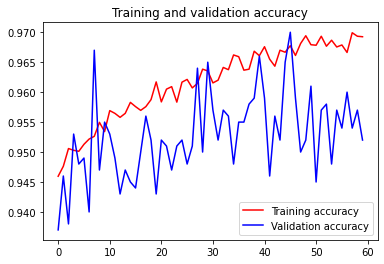

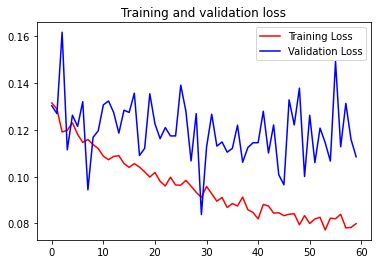

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)
test_data = datagen.flow_from_directory('catsvdogs', classes = ['test'], class_mode = None, shuffle = False, target_size = (150, 150), batch_size = 100)

Found 12500 images belonging to 1 classes.


In [44]:
test_data.reset()

In [45]:
y_pred = model.predict(test_data, verbose = 1, steps = 125)

125/125 [==============================] - 20s 157ms/step


In [85]:
def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = int(''.join(s)) 
      
    return(res) 

fnames = test_data.filenames
fnamesn = []
for i in range(len(fnames)):
    fnamesn.append(convert([int(s) for s in fnames[i] if s.isdigit()]))

In [49]:
[x for _, x in sorted(zip(test_data.filenames, y_pred), key=lambda pair: pair[0])]

[1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,


In [86]:



p = 1
print(fnamesn[0:15])
print(fnamesn[p], y_pred[p])

['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg', 'test/10006.jpg', 'test/10007.jpg', 'test/10008.jpg', 'test/10009.jpg', 'test/1001.jpg']
test/10.jpg 0


In [24]:
print(training_gen.class_indices)

{'cats': 0, 'dogs': 1}


In [47]:
y_pred = np.argmax(y_pred, axis = 1)
y_pred = np.squeeze(y_pred).astype(int)

In [30]:
print(y_pred[4])

1


In [29]:
fnames = test_data.filenames

In [31]:
index = [i+1 for i in range(len(y_pred))]
result = list(zip(index, y_pred))

In [32]:
import pandas as pd

df = pd.DataFrame(result, columns = ['id', 'label'])
print(df)
df.to_csv('catsvdogs/result.csv', index = None)

id  label
0          1      1
1          2      0
2          3      0
3          4      1
4          5      1
...      ...    ...
12495  12496      0
12496  12497      1
12497  12498      1
12498  12499      0
12499  12500      0

[12500 rows x 2 columns]
